# Tâche #1 : Classification d'incidents avec des modèles *Transformers*

On reprend, comme au premier travail, le thème de la classification de descriptions d’incidents. Cependant, la définition des classes est différente pour ce travail et de nouveaux jeux de données ont été produits. Le corpus de textes contient 3 partitions :
-	Un fichier d’entraînement -  *data/incidents_train.json*
-	Un fichier de validation -  *data/incidents_dev.json*
-	Un fichier de test - *data/incidents_test.json*

Utilisez la librairie *HuggingFace* pour accomplir cette tâche. On vous demande plus spécifiquement d’utiliser 2 modèles: le modèle *bert-base-uncased* et un autre modèle de votre choix.

Les consignes pour cette tâche sont:
- Nom du notebook : *t1_classification.ipynb* (ce notebook)
- Tokenisation : Celle fournie par les tokeniseurs accompagnant les modèles transformers.
- Plongements de mots : Ceux du modèle transformer.
- Normalisation : Lettre en minuscule pour Bert (rien à faire, le tokenizer s’en occupe). Aucune contrainte pour le 2e modèle mais il est préférable de ne pas altérer le texte (sauf minuscule).
- Choix du 2e transformer: Un modèle encodeur préentraîné pour l’anglais ou multilingue. Le modèle ne doit pas être une variante de Bert (p. ex. DistilBert). Me consulter en cas de doute.
- Entraînement : Un affinage (*fine-tuning*) du modèle, pas de préentraînement demandé (*no further pretraining*).
- Analyse : Présentez clairement vos résultats et faites-en l’analyse. Comparez les résultats obtenus avec les 2 modèles.    

Vous pouvez ajouter au *notebook* toutes les cellules dont vous avez besoin pour votre code, vos explications ou la présentation de vos résultats. Vous pouvez également ajouter des sous-sections (par ex. des sous-sections 1.1, 1.2 etc.) si cela améliore la lisibilité.

Notes :
- Évitez les bouts de code trop longs ou trop complexes. Par exemple, il est difficile de comprendre 4-5 boucles ou conditions imbriquées. Si c'est le cas, définissez des sous-fonctions pour refactoriser et simplifier votre code.
- Expliquez sommairement votre démarche.
- Expliquez les choix que vous faites au niveau de la programmation et des modèles (si non trivial).
- Analyser vos résultats. Indiquez ce que vous observez, si c'est bon ou non, si c'est surprenant, etc.
- Une analyse quantitative et qualitative d'erreurs est intéressante et permet de mieux comprendre le comportement d'un modèle.

## 1. Création du jeu de données (*les 3 partitions du dataset*)

In [1]:
import json
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, ElectraTokenizer, ElectraForSequenceClassification
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import json

def load_json_data(filename):
    with open(filename, 'r') as fp:
        data = json.load(fp)
    return pd.DataFrame(data)

In [3]:
import json
import pandas as pd
from sklearn.preprocessing import LabelEncoder

In [ ]:

train_df = load_json_data('data/incidents_train.json')
dev_df = load_json_data('data/incidents_dev.json')
test_df = load_json_data('data/incidents_test.json')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
label_encoder = LabelEncoder()
train_df['label'] = label_encoder.fit_transform(train_df['label'])
dev_df['label'] = label_encoder.transform(dev_df['label'])
test_df['label'] = label_encoder.transform(test_df['label'])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


## 2. Création des 2 modèles

### 2.1 Modèle BERT


In [7]:
from transformers import BertTokenizer, BertForSequenceClassification

bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [8]:
model_bert = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))
model_bert.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [9]:
optimizer_bert = AdamW(model_bert.parameters(), lr=1e-5)


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


### 2.2 Deuxième modèle


In [10]:
from transformers import ElectraTokenizer, ElectraForSequenceClassification

electra_tokenizer = ElectraTokenizer.from_pretrained('google/electra-small-discriminator')



tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [11]:
model_electra = ElectraForSequenceClassification.from_pretrained('google/electra-small-discriminator', num_labels=len(label_encoder.classes_))
model_electra.to(device)

pytorch_model.bin:   0%|          | 0.00/54.2M [00:00<?, ?B/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (embeddings_project): Linear(in_features=128, out_features=256, bias=True)
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0-11): 12 x ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Li

In [13]:
optimizer_electra = AdamW(model_electra.parameters(), lr=1e-5)

## 3. Entraînement des 2 modèles

In [12]:

class IncidentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

max_length = 512
batch_size = 16

### 3.1 Modèle BERT


In [14]:
from torch.utils.data import DataLoader

def train_and_validate_model(model, train_loader, val_loader, optimizer, device, num_epochs):
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        total_train_loss = 0
        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_train_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        avg_train_loss = total_train_loss / len(train_loader)
        print(f"Epoch {epoch + 1}/{num_epochs}, Training loss: {avg_train_loss:.4f}")

        # Validation phase
        model.eval()
        val_predictions, val_true_labels = [], []
        total_val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                total_val_loss += loss.item()

                preds = torch.argmax(outputs.logits, dim=1)
                val_predictions.extend(preds.cpu().numpy())
                val_true_labels.extend(labels.cpu().numpy())

        avg_val_loss = total_val_loss / len(val_loader)
        val_accuracy = accuracy_score(val_true_labels, val_predictions)
        val_f1 = f1_score(val_true_labels, val_predictions, average='weighted')

        print(f"Epoch {epoch + 1}/{num_epochs}, Validation loss: {avg_val_loss:.4f}, "
              f"Validation Accuracy: {val_accuracy:.4f}, Validation F1 Score: {val_f1:.4f}")



In [15]:
train_dataset_bert = IncidentDataset(train_df['text'].to_numpy(), train_df['label'].to_numpy(), bert_tokenizer, max_length)
dev_dataset_bert = IncidentDataset(dev_df['text'].to_numpy(), dev_df['label'].to_numpy(), bert_tokenizer, max_length)
train_loader_bert = DataLoader(train_dataset_bert, batch_size=batch_size, shuffle=True)
dev_loader_bert = DataLoader(dev_dataset_bert, batch_size=batch_size, shuffle=False)

In [16]:
num_epochs = 10

train_and_validate_model(model_bert, train_loader_bert, dev_loader_bert, optimizer_bert, device, num_epochs)


Epoch 1/10, Training loss: 1.6794
Epoch 1/10, Validation loss: 1.1195, Validation Accuracy: 0.6874, Validation F1 Score: 0.6274
Epoch 2/10, Training loss: 0.8867
Epoch 2/10, Validation loss: 0.7204, Validation Accuracy: 0.8098, Validation F1 Score: 0.8064
Epoch 3/10, Training loss: 0.6018
Epoch 3/10, Validation loss: 0.6419, Validation Accuracy: 0.8117, Validation F1 Score: 0.8017
Epoch 4/10, Training loss: 0.4584
Epoch 4/10, Validation loss: 0.5831, Validation Accuracy: 0.8173, Validation F1 Score: 0.8144
Epoch 5/10, Training loss: 0.3342
Epoch 5/10, Validation loss: 0.5993, Validation Accuracy: 0.8211, Validation F1 Score: 0.8182
Epoch 6/10, Training loss: 0.2311
Epoch 6/10, Validation loss: 0.6218, Validation Accuracy: 0.8173, Validation F1 Score: 0.8163
Epoch 7/10, Training loss: 0.1516
Epoch 7/10, Validation loss: 0.7195, Validation Accuracy: 0.7966, Validation F1 Score: 0.7979
Epoch 8/10, Training loss: 0.1037
Epoch 8/10, Validation loss: 0.7268, Validation Accuracy: 0.8098, Vali

### 3.2 Deuxième modèle


In [17]:
train_dataset_electra = IncidentDataset(train_df['text'].to_numpy(), train_df['label'].to_numpy(), electra_tokenizer, max_length)
dev_dataset_electra = IncidentDataset(dev_df['text'].to_numpy(), dev_df['label'].to_numpy(), electra_tokenizer, max_length)
train_loader_electra = DataLoader(train_dataset_electra, batch_size=batch_size, shuffle=True)
dev_loader_electra = DataLoader(dev_dataset_electra, batch_size=batch_size, shuffle=False)

In [18]:
num_epochs = 10

train_and_validate_model(model_electra, train_loader_electra, dev_loader_electra, optimizer_electra, device, num_epochs)


Epoch 1/10, Training loss: 2.0207
Epoch 1/10, Validation loss: 1.8837, Validation Accuracy: 0.3955, Validation F1 Score: 0.2242
Epoch 2/10, Training loss: 1.8243
Epoch 2/10, Validation loss: 1.6847, Validation Accuracy: 0.3974, Validation F1 Score: 0.2329
Epoch 3/10, Training loss: 1.5940
Epoch 3/10, Validation loss: 1.4645, Validation Accuracy: 0.5292, Validation F1 Score: 0.4338
Epoch 4/10, Training loss: 1.3907
Epoch 4/10, Validation loss: 1.2937, Validation Accuracy: 0.6102, Validation F1 Score: 0.5119
Epoch 5/10, Training loss: 1.2311
Epoch 5/10, Validation loss: 1.1791, Validation Accuracy: 0.6215, Validation F1 Score: 0.5264
Epoch 6/10, Training loss: 1.1104
Epoch 6/10, Validation loss: 1.1402, Validation Accuracy: 0.6347, Validation F1 Score: 0.5474
Epoch 7/10, Training loss: 1.0119
Epoch 7/10, Validation loss: 1.0450, Validation Accuracy: 0.6516, Validation F1 Score: 0.5744
Epoch 8/10, Training loss: 0.9217
Epoch 8/10, Validation loss: 0.9754, Validation Accuracy: 0.6554, Vali

## 4. Évaluation, analyse de résultats et comparaison des 2 modèles

In [ ]:
test_dataset = IncidentDataset(test_df['text'].to_numpy(), test_df['label'].to_numpy(), bert_tokenizer, max_length)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
def evaluate_model(model, data_loader, device, label_names):
    model.eval()
    predictions, true_labels = [], []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    print("Classification Report:")
    print(classification_report(true_labels, predictions, target_names=label_names))

    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


BERT Model Evaluation on Test Data:
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.78      0.70       103
           1       1.00      0.86      0.92         7
           2       0.86      0.95      0.90        58
           3       0.67      0.80      0.73        15
           4       0.50      0.50      0.50         2
           5       0.91      0.92      0.91       191
           6       0.93      0.90      0.91        29
           7       0.58      0.33      0.42        66
           8       0.58      0.55      0.56        60

    accuracy                           0.77       531
   macro avg       0.74      0.73      0.73       531
weighted avg       0.77      0.77      0.76       531



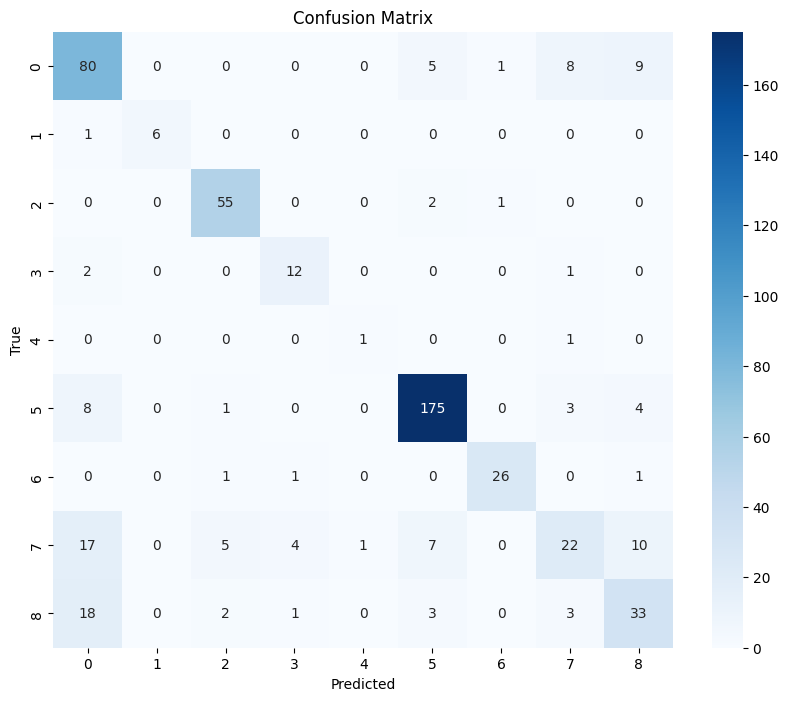

In [21]:
print("BERT Model Evaluation on Test Data:")
evaluate_model(model_bert, test_loader, device, label_encoder.classes_)

Electra Model Evaluation on Test Data:
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.82      0.62       103
           1       0.00      0.00      0.00         7
           2       0.79      0.97      0.87        58
           3       0.00      0.00      0.00        15
           4       0.00      0.00      0.00         2
           5       0.85      0.94      0.89       191
           6       0.68      0.72      0.70        29
           7       0.46      0.36      0.41        66
           8       0.00      0.00      0.00        60

    accuracy                           0.69       531
   macro avg       0.36      0.42      0.39       531
weighted avg       0.58      0.69      0.63       531



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


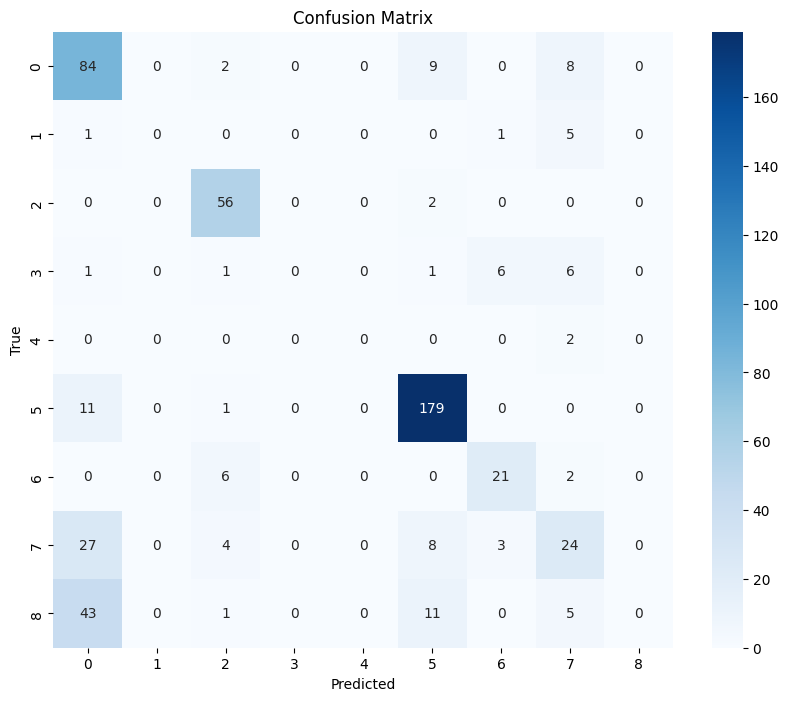

In [23]:
print("Electra Model Evaluation on Test Data:")
evaluate_model(model_electra, test_loader, device, label_encoder.classes_)


### 1. Résultats de Classification

| Modèle   | Précision Globale (pondérée) | Rappel Global | F1-score Global | Exactitude |
|----------|------------------------------|---------------|-----------------|------------|
| ELECTRA  | 0.58                         | 0.69          | 0.63            | 0.69       |
| BERT     | 0.77                         | 0.77          | 0.76            | 0.77       |

**Interprétation :**  
Le modèle BERT surpasse ELECTRA en termes de précision, rappel, F1-score, et exactitude globale. Cela indique que BERT gère mieux la tâche de classification générale et parvient à identifier les classes avec une plus grande fiabilité.

### 2. Analyse des Erreurs de Classification

#### Modèle ELECTRA
- **Classes avec Précision Faible ou Nulle :**  
  Les classes 1, 3, 4, et 8 affichent des scores de précision et de rappel très bas (souvent nuls). Cela suggère des difficultés spécifiques dues à une faible fréquence ou à des caractéristiques ambiguës.
- **Meilleures Performances :**  
  Les classes 2 et 5 affichent des scores élevés en précision et rappel (79%-97% pour la classe 2 et 85%-94% pour la classe 5). Cela indique une bonne représentation dans les données et des caractéristiques distinctives bien capturées.
#### Modèle BERT
- **Classes avec Précision Faible :**  
  La classe 4 obtient une précision et un rappel faibles (50%-50%), ce qui montre des difficultés similaires à ELECTRA pour cette classe.  
- **Meilleures Performances :**  
  Les classes 2, 5, et 6 obtiennent des scores très élevés (f1-score autour de 90%). Ces classes sont bien distinguées par le modèle.  
- **Classe Complexe (8) :**  
  Le rappel pour la classe 8 est faible (55%), mais nettement meilleur que celui d'ELECTRA, montrant une certaine capacité à capturer les caractéristiques de cette classe.  

### 3. Identification des Classes Complexes
- **Classe 8 :** Les deux modèles ont des performances faibles sur cette classe, en particulier ELECTRA, qui ne prédit aucune instance correctement.  
- **Classe 1 :** Bien que BERT ait un rappel élevé (86%), ELECTRA échoue complètement sur cette classe.  
- **Classe 7 :** Les scores moyens de précision et de rappel pour les deux modèles (33%-36% pour ELECTRA et 58%-33% pour BERT) indiquent que cette classe reste un défi pour les deux.

### 4. Conclusion et Recommandations
- **Choix du Modèle :**  
  BERT est préféré pour cette tâche grâce à ses performances globalement meilleures et plus équilibrées.  
- **Classes Difficiles :**  
  Les classes 1, 7, et 8 nécessitent davantage de données ou des techniques de prétraitement spécifiques.  
- **Résumé :**  
  BERT est mieux adapté pour la classification générale, mais ELECTRA reste une alternative valable pour des classes spécifiques comme 2 et 5.

"""